In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs
import torch_mvae_util as U

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(int(cfg_model.img_size * 1.5)), 
        Rd.CenterCrop(int(cfg_model.img_size * 1.5)), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 80
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  7840 
test set size:  2027


In [5]:
model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'image_feature_size': cfg_model.image_feature_size,
    'emotion_feature_size': cfg_model.emotion_feature_size,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'loss_weights' : cfg_model.loss_weights,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : True
}
print(model_args)
train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}
print(train_args)

{'cat_dim': 8, 'latent_space_dim': 50, 'image_feature_size': 128, 'emotion_feature_size': 16, 'hidden_dim': 256, 'num_filters': 128, 'loss_weights': {'face': 1.0, 'emotion': 10000.0}, 'expert_type': 'moe', 'use_cuda': True}
{'learning_rate': 5e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 50, 'batch_size': 32}


In [6]:
model: torch.nn.Module = build_model(**model_args).double()

In [7]:
load_model = False

if load_model:    
    PATH = "../trained_models/ravdess_InfoVAE.save"
    loaded_data = torch.load(PATH)
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_params'])
    
    training_losses = loaded_data['training_loss']    
    model.eval()

In [8]:
train_model = True

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        batch_size=cfg_train.batch_size,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train,
        checkpoint_every=cfg_train.checkpoint_every,
        resume_train = False
    )

100%|███████████████████████████████████████████████████████████████████| 50/50 [1:08:11<00:00, 81.82s/it]


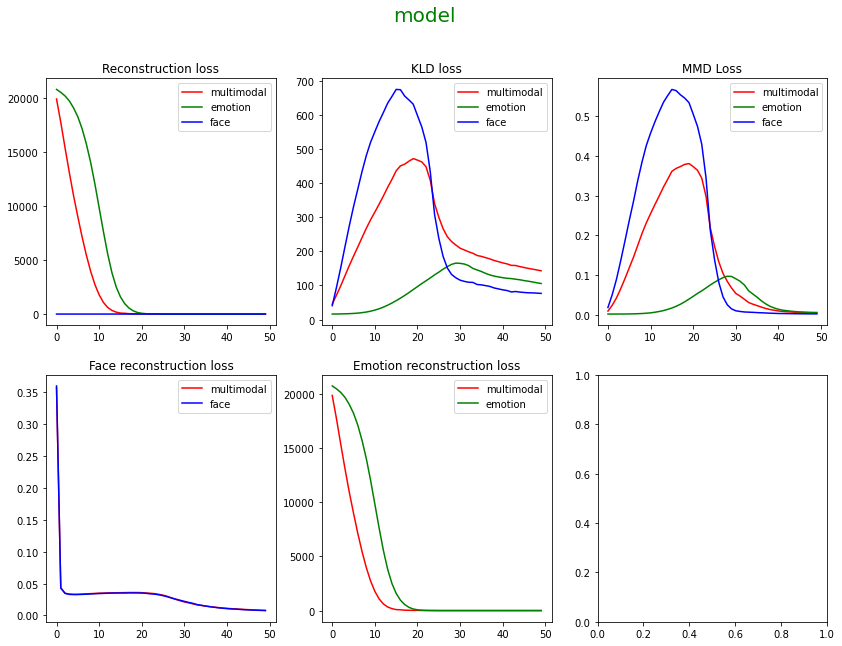

In [9]:
U.print_losses(training_losses, 'model')

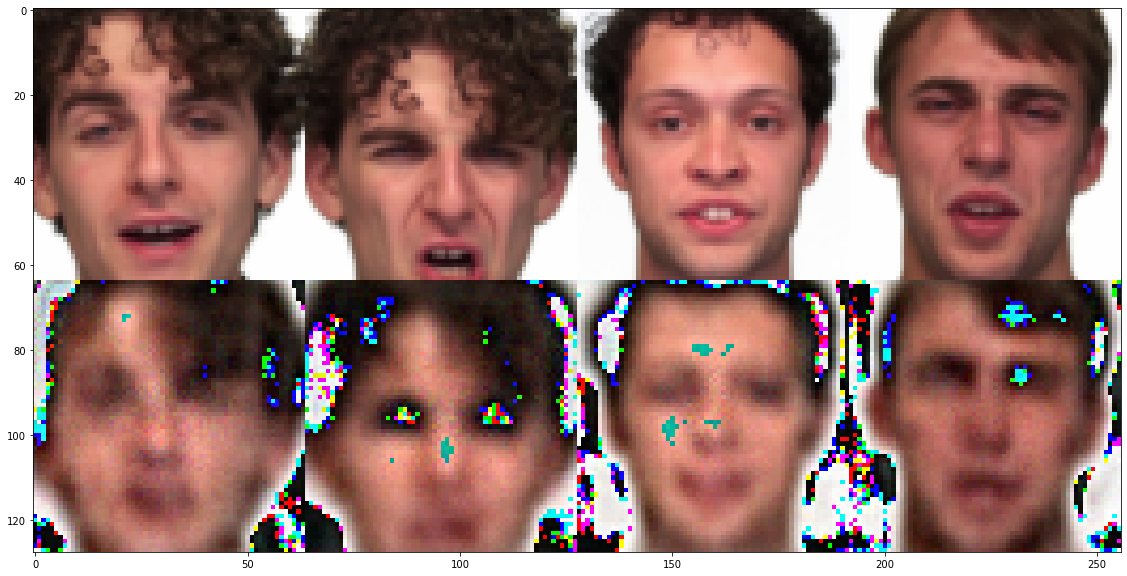

In [10]:
img = U.images_to_images(model, testset_loader, num_images=4, model_eval=True)

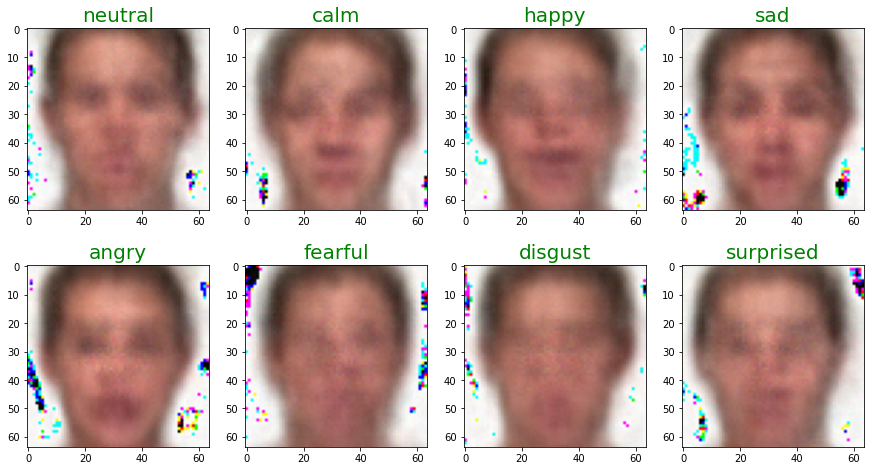

In [11]:
rec_image = U.emotions_to_images(model, model_eval=True)

In [12]:
save_model = True

if save_model:
    PATH = "../trained_models/moe.save"
    torch.save({#'rec_image' : rec_image,
                'model_args' : model_args,
                'training_loss' : training_losses,
                'train_args': train_args,
                'model_params' : model.state_dict()
               }, PATH)

In [13]:
acc, errs = U.recon_and_classiffication_accuracy(model, dataset_loader, model_eval=True)
print("Reconstruction and classification accuracy: ", acc)
print("Reconstruction and classification accuracy per emotion: ")
for idx, e in enumerate(errs):
    print(Rd.emocat[idx], "acc:\t", e.item())

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.92it/s]

Reconstruction and classification accuracy:  0.375
Reconstruction and classification accuracy per emotion: 
neutral acc:	 1.0
calm acc:	 0.3177083432674408
happy acc:	 0.0
sad acc:	 0.0
angry acc:	 0.0
fearful acc:	 0.18617020547389984
disgust acc:	 0.6122449040412903
surprised acc:	 0.9601989984512329


In [14]:
print(U.classiffication_accuracy(model, testset_loader, model_eval=True))

100%|█████████████████████████████████████████████████████████████████████| 64/64 [00:14<00:00,  4.49it/s]

0.7947705969412926


# 